# Machine Learning models on Mismatch Response data

In this notebook: 
- Necessary imports
- SVM model 
- Logistic Regression model
- Decision Tree model

## Imports

In [1]:
import os       # using operating system dependent functionality (folders)
import pandas as pd # data analysis and manipulation
import numpy as np    # numerical computing (manipulating and performing operations on arrays of data)
import copy     # Can Copy and Deepcopy files so original file is untouched.
import seaborn as sn
import matplotlib.pyplot as plt
import ipywidgets as widgets

import sys
sys.path.insert(0, '../eegyolk') # path to helper functions
import helper_functions as hf # library useful for eeg and erp data cleaning
import epod_helper

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold 

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Reshape
from tensorflow.keras.layers import Conv1D,BatchNormalization,LeakyReLU,MaxPool1D,\
GlobalAveragePooling1D,Dense,Dropout,AveragePooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow import keras
from tensorflow.keras import layers

2022-11-02 09:55:52.491698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 09:55:52.600447: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-02 09:55:52.629261: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 09:55:53.177576: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [2]:
csv = widgets.RadioButtons(
    options=['df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mmr_ch_ttest.csv', 'df_mmr_ch_connectivity.csv'],
    description='Pick sensors',
    disabled=False
)
display(csv)

RadioButtons(description='Pick sensors', options=('df_mmr_ch_complete.csv', 'df_mmr_ch_literature.csv', 'df_mm…

In [3]:
csv = str(csv.value)

In [4]:
df = pd.read_csv(csv, sep = ',')

In [5]:
dfcor = df.corr()

In [6]:
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(dfcor, 10))

Top Absolute Correlations
std_P7   std_P8     0.994686
min_O1   min_PO3    0.987309
std_P7   std_PO3    0.986210
std_P8   std_PO3    0.985413
min_O1   min_P8     0.984188
min_P8   min_PO3    0.982480
std_P8   min_P8     0.977074
std_P4   std_P8     0.975026
min_AF3  min_Fp1    0.974621
std_P8   min_O1     0.973582
dtype: float64


## Split data

In [7]:
y = df['Group_AccToParents'].values # dependent variable
X = df.drop(['Group_AccToParents',
       'sex'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

## Scale data

In [8]:
sc = StandardScaler()
sc.fit(X_train)
X_train = sc.transform(X_train)
X_test = sc.transform(X_test)

## Select model

In [9]:
model_pick = widgets.RadioButtons(
    options=['SVM', 'Logistic Regression', 'Decision Tree', 'Multi Layer Perceptron', 'Convolutional Neural Network'],
    description='Pick model',
    disabled=False
)
display(model_pick)

RadioButtons(description='Pick model', options=('SVM', 'Logistic Regression', 'Decision Tree', 'Multi Layer Pe…

In [10]:
model_pick = str(model_pick.value)

## SVM model

In [11]:
svm = SVC()
parameters = {'kernel':('linear', 'poly', 'rbf', 'sigmoid'), 'C':[0.0001, 1000], 'gamma':('auto','scale')}
clf = GridSearchCV(svm, parameters)
clf.fit(X_train, y_train)
#sorted(clf.cv_results_.keys())

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.0001, 1000], 'gamma': ('auto', 'scale'),
                         'kernel': ('linear', 'poly', 'rbf', 'sigmoid')})

In [12]:
clf.score(X_train, y_train)

0.85

In [13]:
svm = SVC(C=clf.best_params_.get('C'), kernel=clf.best_params_.get('kernel'), gamma=clf.best_params_.get('gamma')) #C=0.0001, kernel='linear', gamma='auto', random_state=True
svm.fit(X_train, y_train)

SVC(C=1000, kernel='sigmoid')

In [14]:
y_pred = svm.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.537


In [15]:
y_pred

array([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

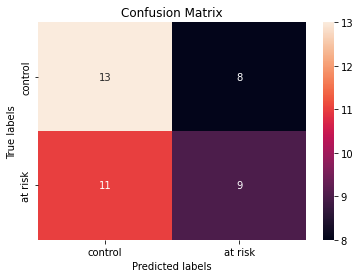

In [16]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [17]:
# with kfold cross validation
k = 6
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = svm
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    print(pred_values)
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0]
[0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0]
[1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 0 1]
[1 1 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0]
[1 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0]
[0 1 0 0 0 1 1 1 1 0 1 0 0 1 1 0]
accuracy of each fold - [0.47058823529411764, 0.47058823529411764, 0.6470588235294118, 0.7058823529411765, 0.5882352941176471, 0.5625]
Avg accuracy : 0.5741421568627452


## Logistic Regression model

In [19]:
lr = LogisticRegression()
parameters = {'C':[0.0001, 1000], 'max_iter': [4000,5000],
              'solver': ('liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga')} #'penalty':('l1', 'l2', 'elasticnet')
clf = GridSearchCV(lr, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.0001, 1000], 'max_iter': [4000, 5000],
                         'solver': ('liblinear', 'newton-cg', 'lbfgs', 'sag',
                                    'saga')})

In [20]:
lr = LogisticRegression(C=clf.best_params_.get('C'),
                       solver=clf.best_params_.get('solver'))
lr.fit(X_train, y_train)

LogisticRegression(C=1000, solver='liblinear')

In [21]:
y_pred = lr.predict(X_test)

In [22]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.680


In [23]:
y_pred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1])

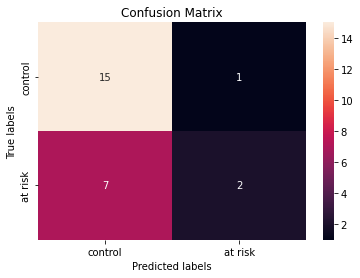

In [24]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [25]:
# with kfold cross validation
k = 4
kf = KFold(n_splits=k, shuffle = True, random_state=None)
model = lr
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
    print(pred_values)
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
accuracy of each fold - [0.5384615384615384, 0.6, 0.64, 0.56]
Avg accuracy : 0.5846153846153846


## Decision Tree model

In [11]:
dt = tree.DecisionTreeClassifier()
parameters = {'criterion':('gini', 'entropy', 'log_loss'), 'splitter': ('random', 'best'), 'max_depth' : [2,20]}
clf = GridSearchCV(dt, parameters)
clf.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ('gini', 'entropy', 'log_loss'),
                         'max_depth': [2, 20], 'splitter': ('random', 'best')})

In [12]:
dt = tree.DecisionTreeClassifier(criterion=clf.best_params_.get('criterion'), splitter=clf.best_params_.get('splitter'),
                                 max_depth=clf.best_params_.get('max_depth'))
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=2)

In [13]:
y_pred = dt.predict(X_test)

In [14]:
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

Accuracy: 0.585


In [15]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0])

[Text(0.6, 0.8333333333333334, 'X[58] <= 1.105\nentropy = 0.96\nsamples = 60\nvalue = [37, 23]'),
 Text(0.4, 0.5, 'X[15] <= -1.084\nentropy = 0.867\nsamples = 52\nvalue = [37, 15]'),
 Text(0.2, 0.16666666666666666, 'entropy = 0.0\nsamples = 4\nvalue = [0, 4]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.777\nsamples = 48\nvalue = [37, 11]'),
 Text(0.8, 0.5, 'entropy = 0.0\nsamples = 8\nvalue = [0, 8]')]

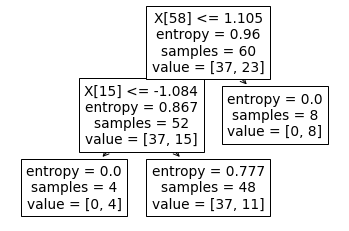

In [16]:
tree.plot_tree(dt)

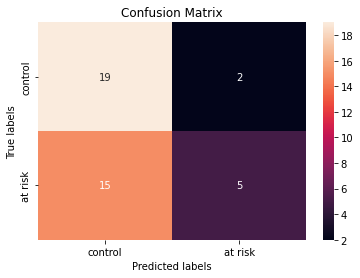

In [17]:
cm = confusion_matrix(y_test, y_pred)
ax= plt.subplot()
sn.heatmap(cm, annot=True, fmt='g', ax=ax);  
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['control', 'at risk']); ax.yaxis.set_ticklabels(['control', 'at risk']);

In [18]:
# with kfold cross validation
k = 4
kf = KFold(n_splits=k, shuffle=True, random_state=None)
model = tree.DecisionTreeClassifier(max_depth=5)
 
acc_score = []
 
for train_index , test_index in kf.split(X):
    X_train , X_test = X.iloc[train_index,:],X.iloc[test_index,:]
    y_train , y_test = y[train_index] , y[test_index]
     
    model.fit(X_train,y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values , y_test)
    acc_score.append(acc)
     
avg_acc_score = sum(acc_score)/k
 
print('accuracy of each fold - {}'.format(acc_score))
print('Avg accuracy : {}'.format(avg_acc_score))

accuracy of each fold - [0.5, 0.64, 0.6, 0.4]
Avg accuracy : 0.535


## CNN

In [79]:
y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

In [82]:
model = Sequential()
model.add(Dense(8, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
opt = keras.optimizers.Adam(learning_rate=0.1)
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
model.fit(X_train, y_train,epochs=50, batch_size=1, verbose=1,validation_data=(X_test, y_test))

Epoch 1/50
85/85 [==============================] - 1s 3ms/step - loss: 0.7025 - accuracy: 0.5294 - val_loss: 0.6651 - val_accuracy: 0.6250
Epoch 2/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7079 - accuracy: 0.5059 - val_loss: 0.6685 - val_accuracy: 0.6250
Epoch 3/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7015 - accuracy: 0.5176 - val_loss: 0.6620 - val_accuracy: 0.6250
Epoch 4/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6985 - accuracy: 0.5647 - val_loss: 0.6672 - val_accuracy: 0.6250
Epoch 5/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6925 - accuracy: 0.5647 - val_loss: 0.6838 - val_accuracy: 0.6250
Epoch 6/50
85/85 [==============================] - 0s 1ms/step - loss: 0.7011 - accuracy: 0.5647 - val_loss: 0.6681 - val_accuracy: 0.6250
Epoch 7/50
85/85 [==============================] - 0s 1ms/step - loss: 0.6976 - accuracy: 0.5059 - val_loss: 0.6616 - val_accuracy: 0.6250
Epoch 8/50
85/85 [==

# MLP

In [87]:
from sklearn.neural_network import MLPClassifier

NN = MLPClassifier()
parameters = {'activation':('identity', 'relu', 'logistic', 'tanh'), 'alpha':[0.00001, 10], 'solver':('lbfgs','sgd', 'adam'),
              'learning_rate':('invscaling', 'adaptive'), 'max_iter': [4000,5000]}
clf = GridSearchCV(NN, parameters)
clf.fit(X_train, y_train)

NN = MLPClassifier(activation=clf.best_params_.get('activation'), alpha=clf.best_params_.get('alpha'), solver=clf.best_params_.get('solver'),
                  learning_rate=clf.best_params_.get('learning_rate'), max_iter=clf.best_params_.get('max_iter'))
NN.fit(X_train, y_train)
y_pred = NN.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, y_pred))

/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning

Accuracy: 0.625


/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/nprins/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1118: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
